In [1]:
# libraries, data exploration, data cleaning
# I turned 'gender' into a dummy variable instead of using onehotencoder because there were two genders
# and the 'other' variable had only 1 value, so I dropped it


import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('https://raw.githubusercontent.com/nickkas/python_ml_ect_/master/stroke.csv')
df.info()

df.isna().sum()
df.nunique()

df['gender'].value_counts()
df['gender'] = pd.get_dummies(df.gender,prefix='gender').iloc[:,0:1]

df['id'].value_counts()

df['stroke'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


0    4861
1     249
Name: stroke, dtype: int64

In [2]:
# determining the features that lead individuals to having a stroke
# 'id' was not needed at all

X = df.drop(['id','stroke'],axis=1)
y = df[['stroke']]


In [3]:
#train/test split models used are KNeighbors, Random Forest, Logistic regression, and Naive Bayes

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB




clf = LogisticRegression()

rfc = RandomForestClassifier()

knn = KNeighborsClassifier(n_neighbors=3)

nb = GaussianNB()

GBC = GradientBoostingClassifier()

In [4]:
# I used pandas 'get_dummies' earlier for gender, however, the are plenty of features in this dataset
# that are string and need to be converted into numerical values. Also, simpleimputer is used as well to filled the missing 
# values in 'BMI'. The models selected above are then ran through a pipeline.


from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

ohe = OneHotEncoder()
imputer = SimpleImputer()

ct = make_column_transformer(
    (ohe,['ever_married','work_type','Residence_type','smoking_status']),
    (imputer,['bmi']),remainder='passthrough')


ct.fit_transform(X)



from sklearn.pipeline import make_pipeline

clf_pipe = make_pipeline(ct,clf).fit(X_train,y_train)
clf_pred = clf_pipe.predict(X_test)
clf_pred_prob = clf_pipe.predict_proba(X_test)[::,1]


rfc_pipe = make_pipeline(ct,rfc).fit(X_train,y_train)
rfc_pred = rfc_pipe.predict(X_test)
rfc_pred_prob = rfc_pipe.predict_proba(X_test)[::,1]


knn_pipe = make_pipeline(ct,knn).fit(X_train,y_train)
knn_pred = knn_pipe.predict(X_test)
knn_pred_prob = knn_pipe.predict_proba(X_test)[::,1]



nb_pipe = make_pipeline(ct,nb).fit(X_train,y_train)
nb_pred = nb_pipe.predict(X_test)
nb_pred_prob = nb_pipe.predict_proba(X_test)[::,1]


GBC_pipe = make_pipeline(ct,GBC).fit(X_train,y_train)
GBC_pred = GBC_pipe.predict(X_test)
GBC_pred_prob = GBC_pipe.predict_proba(X_test)[::,1]


In [5]:
# Evaluation of the models
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score

def evaluate_model(model_name,y_true,y_pred,y_pred_prob):
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred_prob)
    print(f'{model_name} - Accuracy: {acc * 100:.2f}%, ROC-AUC: {roc * 100:.2f}%')

evaluate_model('Logistic Regression', y_test,clf_pred,clf_pred_prob)
evaluate_model('Random Forest', y_test,rfc_pred,rfc_pred_prob)
evaluate_model('Naive Bayes', y_test,nb_pred,nb_pred_prob)
evaluate_model('Gradient Boosting',y_test,GBC_pred,GBC_pred_prob)
evaluate_model('KNN', y_test,knn_pred, knn_pred_prob)


Logistic Regression - Accuracy: 93.93%, ROC-AUC: 85.13%
Random Forest - Accuracy: 93.84%, ROC-AUC: 79.45%
Naive Bayes - Accuracy: 52.35%, ROC-AUC: 82.75%
Gradient Boosting - Accuracy: 94.03%, ROC-AUC: 83.33%
KNN - Accuracy: 93.54%, ROC-AUC: 62.55%


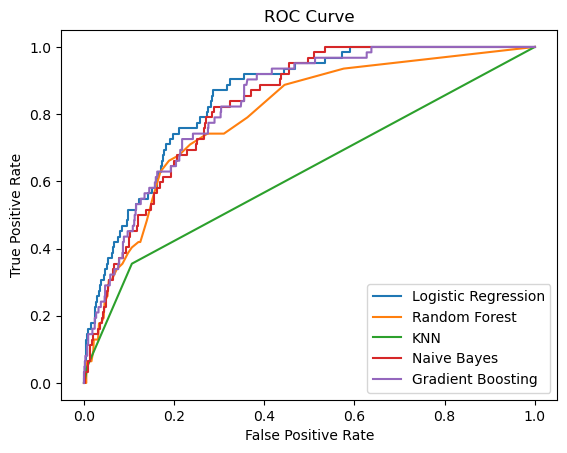

In [6]:
# ROC curve plotted
def roc_curve_plot(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.plot(fpr,tpr,label=model_name)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

roc_curve_plot(y_test,clf_pred_prob,'Logistic Regression')
roc_curve_plot(y_test,rfc_pred_prob,'Random Forest')
roc_curve_plot(y_test,knn_pred_prob,'KNN')
roc_curve_plot(y_test,nb_pred_prob,'Naive Bayes')
roc_curve_plot(y_test,GBC_pred_prob,'Gradient Boosting')
plt.legend()
plt.show()